In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical, SeveralSourceDataset
from data import data_dirs as data_env, get_label_with_context

from model import (
    LinkNet34,
    accuracy_segmentation, tensorboard_cb, jaccard_index_one_class, jaccard_index_zero_class
)

from result_visualization import show_results

from fastai.vision import (
    Learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,    # matplotlib.pyplot
    nn,     # torch.nn
    optim,  # torch.optim
    Tensor, # torch.Tensor
)
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

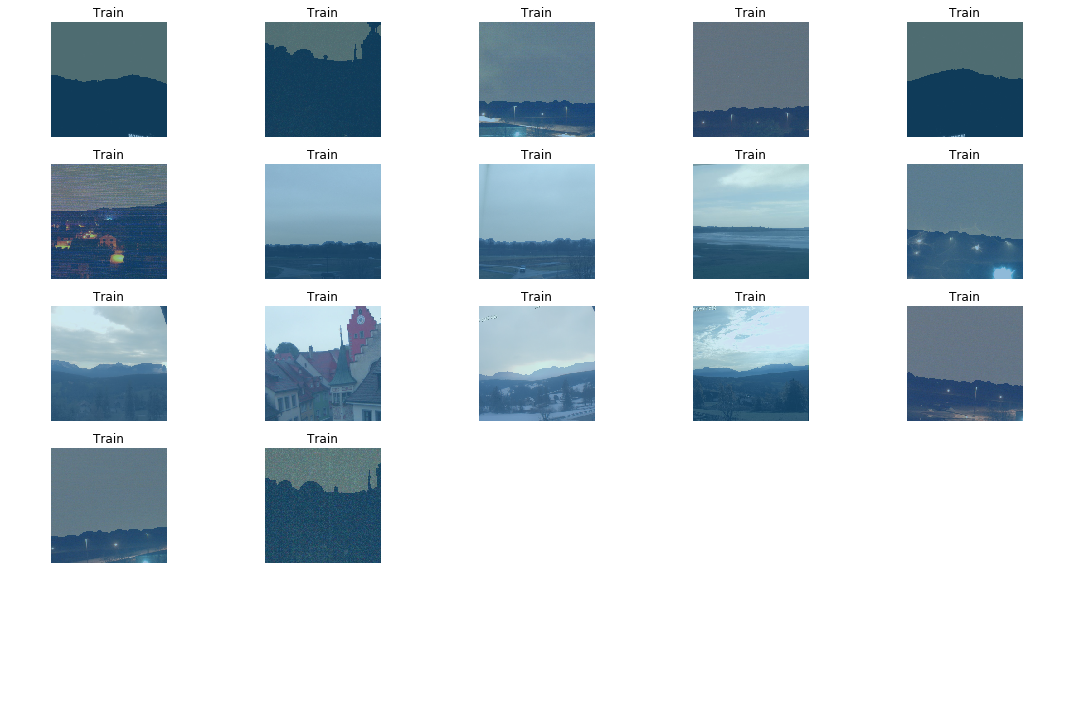

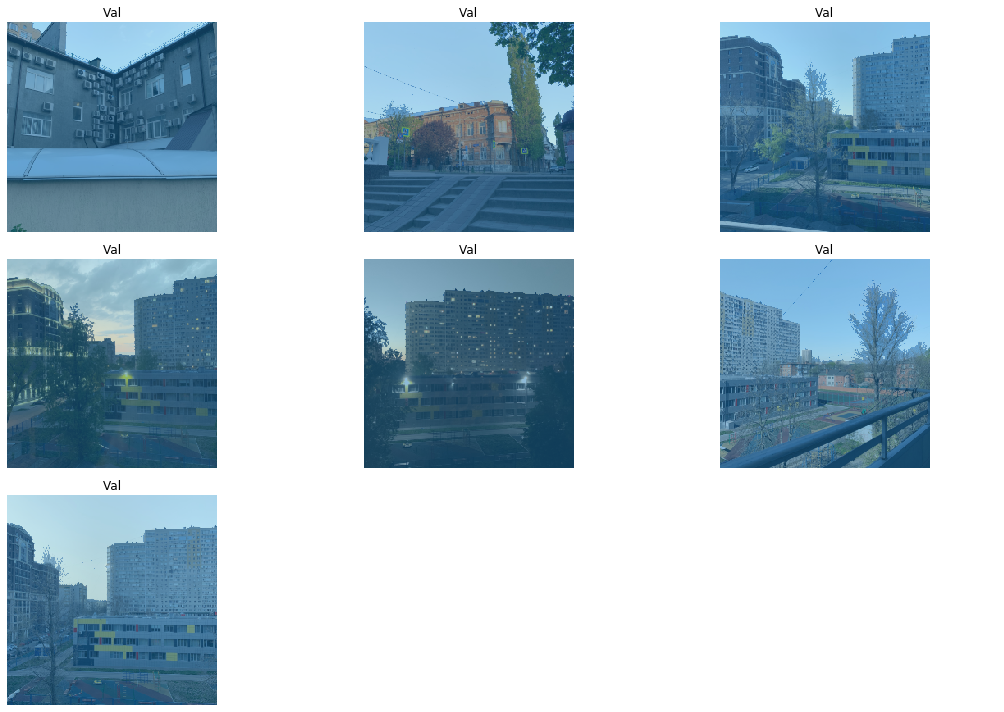

In [2]:
sizes = 256

src = (
    SegItemListCustom
    .from_folder(data_env.get_subdir("root"))
    .split_by_folder("train_skyFinder", "test_iphoneXR_v")
    .label_from_func(get_label_with_context,
                     classes=["Sky", "Other"])
)
train_data = (
    src
    .transform(tfms=get_transforms()
                  , size=sizes, tfm_y=True)
    .databunch(bs=17)
    .normalize(imagenet_stats)
)
classes = train_data.c
train_data.valid_dl.batch_size = 7

train_data.show_batch(figsize=(15,10), title="Train")
train_data.show_batch(figsize=(15,10), title="Val", ds_type=DatasetType.Valid)

In [3]:
model = LinkNet34(num_classes=classes)

learner = Learner(train_data, model)
learner.opt_fn = optim.Adam
learner.loss_fn = nn.BCELoss()  # pos_weight=Tensor([1])
learner.metrics = [accuracy_segmentation, jaccard_index_one_class, jaccard_index_zero_class]

# learner.freeze_to(1)

In [4]:
learner

Learner(data=ImageDataBunch;

Train: LabelList (12863 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /home/dmitri/Documents/Datasets/skyFinderMod;

Valid: LabelList (7 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /home/dmitri/Documents/Datasets/skyFinderMod;

Test: None, model=LinkNet34(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  

In [13]:
print("Model: LinkNet34")

print("Trainable: {}".format(t_sum))

sum = 0
t_sum = 0
for name, p in learner.model.named_parameters():
    t = 0
    if p.requires_grad:
        t = p.numel()
    print("Layer: {0}, parameters: {1}, trainable: {2}".format(name, p.numel(), t))
    sum += p.numel()
    t_sum += t

Model: LinkNet34
Trainable: 21794850
Layer: firstconv.weight, parameters: 9408, trainable: 9408
Layer: firstbn.weight, parameters: 64, trainable: 64
Layer: firstbn.bias, parameters: 64, trainable: 64
Layer: encoder1.0.conv1.weight, parameters: 36864, trainable: 36864
Layer: encoder1.0.bn1.weight, parameters: 64, trainable: 64
Layer: encoder1.0.bn1.bias, parameters: 64, trainable: 64
Layer: encoder1.0.conv2.weight, parameters: 36864, trainable: 36864
Layer: encoder1.0.bn2.weight, parameters: 64, trainable: 64
Layer: encoder1.0.bn2.bias, parameters: 64, trainable: 64
Layer: encoder1.1.conv1.weight, parameters: 36864, trainable: 36864
Layer: encoder1.1.bn1.weight, parameters: 64, trainable: 64
Layer: encoder1.1.bn1.bias, parameters: 64, trainable: 64
Layer: encoder1.1.conv2.weight, parameters: 36864, trainable: 36864
Layer: encoder1.1.bn2.weight, parameters: 64, trainable: 64
Layer: encoder1.1.bn2.bias, parameters: 64, trainable: 64
Layer: encoder1.2.conv1.weight, parameters: 36864, train

epoch,train_loss,valid_loss,accuracy_segmentation,jaccard_index_one_class,jaccard_index_zero_class,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E+00
Min loss divided by 10: 3.63E-04


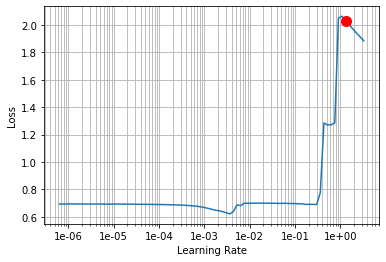

In [5]:
learner.lr_find()
learner.recorder.plot(suggestion=True, show_grid=True)

In [4]:
tb_callback = tensorboard_cb("/home/dmitri/Documents/tensorboard_logs", log_name="linknet34_const_full_s256_mlr1e03_e25_bs17_without_logit_dropout_10")

epoch,train_loss,valid_loss,accuracy_segmentation,jaccard_index_one_class,jaccard_index_zero_class,time
0,0.059226,0.246630,0.919686,73.490092,89.668381,03:58
1,0.057688,0.153933,0.931009,76.041422,91.166595,03:59
2,0.053246,0.276933,0.882614,64.793143,85.026707,03:58
3,0.046803,0.084980,0.965703,86.325277,95.622477,03:58
4,0.040522,0.067283,0.978006,90.852055,97.185841,03:59
5,0.030141,0.094830,0.973363,88.908253,96.613082,04:01
6,0.026856,0.077513,0.972857,88.785821,96.542705,04:00
7,0.024199,0.063973,0.979747,91.502341,97.409864,03:59
8,0.021984,0.078561,0.968384,87.379486,95.952357,03:59
9,0.019137,0.069210,0.976565,90.308040,97.001751,04:01


profiler execution failed


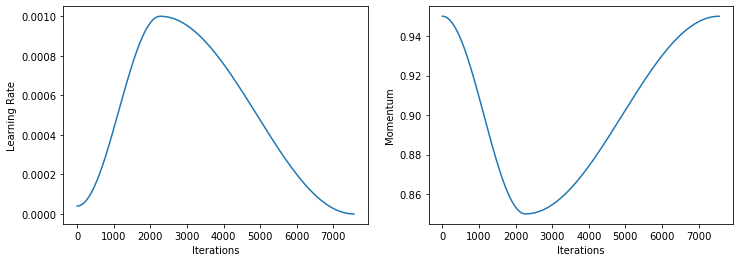

In [5]:
learner.fit_one_cycle(10, max_lr=1e-03, callbacks=[tb_callback(learner)], )
# learner.fit(25, lr=1e-03, callbacks=[tb_callback(learner)])
# learner.fit(10)
# learner.fit_one_cycle(10, max_lr=2e-01)
learner.recorder.plot_lr(show_moms=True)

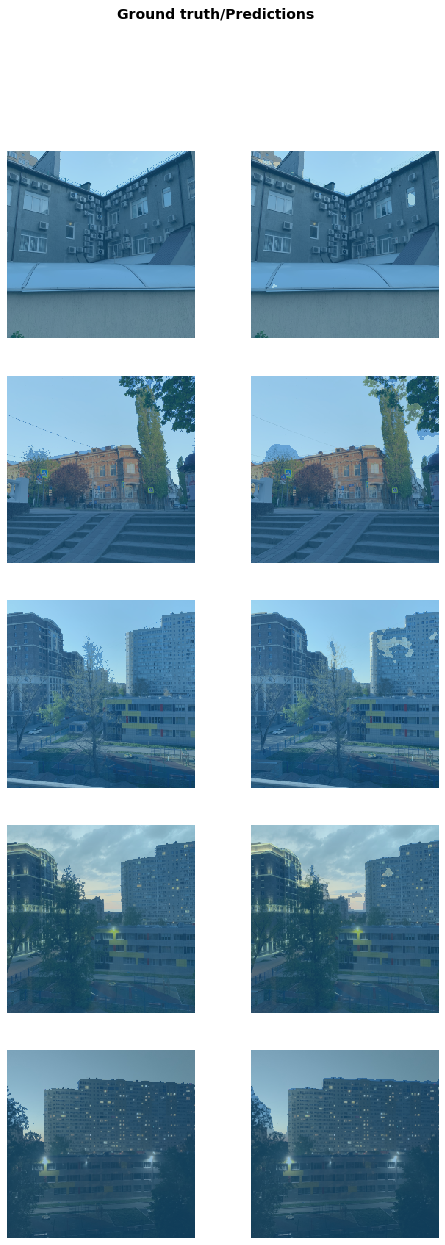

In [6]:
learner.show_results()

In [1]:
learner.save("/home/dmitri/Documents/model_weights/linknet34/linknet34_osp_full_e25_wghts_without_logit_1e-03_dropout_10")
learner.export("/home/dmitri/Documents/model_weights/linknet34/linknet34_osp_full_e25_exp_without_logit_1e-03_dropout_10")

NameError: name 'learner' is not defined

In [9]:
classes

2